## Part 1: Working with data in `PyTorch`
<a id=part1></a>

In this part, we'll learn about the `Dataset` and `DataLoader` classes which are part of `PyTorch`'s `torch.util.data` package.
These are highly useful abstractions that can greatly reduce the amount of boilerplate code you need to write in order to work with data.
Knowing how to use these classes properly will prove useful in the coming assignments and course project.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(42)
test = unittest.TestCase()

### Datasets
<a id=part1_1></a>

The `Dataset` class is an abstraction over a sequence of python objects,
each representing a sample (with or without a label). it's main purpose is
to load a single (possibly labeled) sample from some soure (disk, web, etc) into memory,
and transform it into a usuable representation (e.g. image to tensor).

The `Dataset` abstracts away exactly when the data is loaded into memory: It can be on
demand when each sample is accessed, all in advance or some combination using e.g. caching.
This is implementation-specific.

As a warm up, lets create a demonstration `Dataset` that returns noise images. It should:
- Return tensors of shape `(C, W, H)` containing random contents.
- Label each returned tensor with a class label, an integer between `0` and `num_classes-1`.
- Initialize each returned tensor with a uniform distribution on `[0, 255]`.
- Return a total of `num_samples` labeled images.
- The same image should be returned every time the dataset is accessed as the same index.

First, let's implement a simple function to generate a labelled random image.

**TODO** Implement the `random_labelled_image` function in the `hw1/datasets.py` module.
Use the code below to test your implementation.

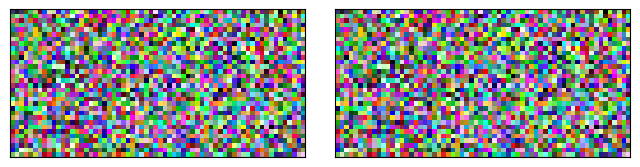

In [2]:
import hw1.datasets as hw1datasets
import cs236781.plot as plot

image_shape = (3, 32, 64)
num_classes = 3
low, high = 0, 10

# Generate some random images and check values
X_ = None
for i in range(100):
    X, y = hw1datasets.random_labelled_image(image_shape, num_classes, low, high)
    test.assertEqual(X.shape, image_shape)
    test.assertIsInstance(y, int)
    test.assertTrue(0<= y < num_classes)
    test.assertTrue(torch.all((X >= low) & (X < high)))
    if X_ is not None:
        test.assertFalse(torch.all(X == X_))
    X_ = X
    
plot.tensors_as_images([X, X_]);

In many cases we'll need to consistently get repeatable results even though we're using pseudo-random number generators (PRNGs).
The way to do this is to provide a seed to the generator.
Given the same seed, a PRNG will always generate the same sequence of numbers.

Here, we need a way to generate the same random image when accessing our dataset at the same index (e.g. to simulate a real set of images).

**TODO** Implement the `torch_temporary_seed` function in the `hw1/datasets.py` module.
Use the code below to test your implementation.

In [3]:
seeds = [42, 24]
torch.random.manual_seed(seeds[0])

# Before the context, the first seed affects the output
data_pre_context = torch.randn(100,)

with hw1datasets.torch_temporary_seed(seeds[1]):
    # Within this context, the second seed is in effect
    data_in_context = torch.randn(100,)
    
# After the context, the random state should be restored
data_post_context = torch.randn(100,)
data_around_context = torch.cat([data_pre_context, data_post_context])

# Use first seed, generate data in the same way but without changing context in the middle
torch.random.manual_seed(seeds[0])
data_no_context = torch.cat([torch.randn(100,), torch.randn(100,)])

# Identical results show that the context didn't affect external random state
test.assertTrue(torch.allclose(data_no_context, data_around_context))

# The data generated in the context should match what we would generate with the second seed
torch.random.manual_seed(seeds[1])
test.assertTrue(torch.allclose(data_in_context, torch.randn(100,)))

Now we can implement the dataset as required.

**TODO** Implement the `RandomImageDataset` class in the `hw1/datasets.py` module.
Use the code below to test your implementation.

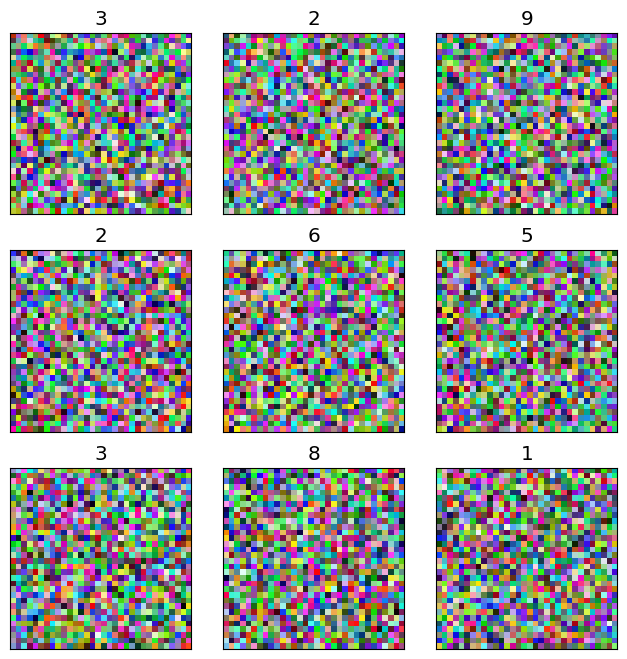

In [4]:
# Test RandomImageDataset

# Create the dataset
num_samples = 500
num_classes = 10
image_size = (3, 32, 32)
ds = hw1datasets.RandomImageDataset(num_samples, num_classes, *image_size)

# You can load individual items from the dataset by indexing
img0, cls0 = ds[139]

# Plot first N images from the dataset with a helper function
fig, axes = plot.dataset_first_n(ds, 9, show_classes=True, nrows=3)

# The same image should be returned every time the same index is accessed
for i in range(num_samples):
    X, y = ds[i]
    X_, y_ = ds[i]
    test.assertEqual(X.shape, image_size)
    test.assertIsInstance(y, int)
    test.assertEqual(y, y_)
    test.assertTrue(torch.all(X==X_))
    
# Should raise if out of range
for i in range(num_samples, num_samples+10):
    with test.assertRaises(ValueError):
        ds[i]

This simple dataset is a useful abstraction when we know in advance the number of samples in our dataset and can access them by indexing. However, in many cases we simply cannot know about all data in advance. For example, perhaps new data is generated in real time.

To deal with these cases, we can use a different type of abstraction: an `IterableDataset` which provides an interface only to iterate over samples, but not to index them directly.
Let's implement such a dataset which will allow us to iterate over an infinite stream of randomly-generated images.

In [5]:
ds = hw1datasets.ImageStreamDataset(num_classes, *image_size)

# This dataset can't be indexed
with test.assertRaises(NotImplementedError):
    ds[0]
    
# There is no length
with test.assertRaises(TypeError):
    len(ds)
    
# Arbitrarily stop somewhere
stop = torch.randint(2**11, 2**16, (1,)).item()
    
# We can iterate over it, indefinitely
for i, (X, y) in enumerate(ds):
    test.assertEqual(X.shape, image_size)
    test.assertIsInstance(y, int)
    
    if i > stop:
        break
        
print(f'Generated {i} images')
test.assertGreater(i, stop)

Generated 22112 images


### Built-in Datasets and Transforms
<a id=part1_2></a>

Now that we've created a simple `Dataset` to see how they work, we'll load one of `pytorch`'s built-in datasets: CIFAR-10. This is a famous dataset consisting of 60,000 small `32x32` color images classified into 10 classes. You can read more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html).

The `torchvision` package has built-in `Dataset` classes that can download the data to a local folder,
load it, transform it using arbitrary transform functions and iterate over the resulting samples.

Run the following code block to download and create a CIFAR-10 `Dataset`. It won't be downloaded again if already present.

Run the following block to download CIFAR-10 and plot some random images from it.

Files already downloaded and verified


Number of samples: 50000


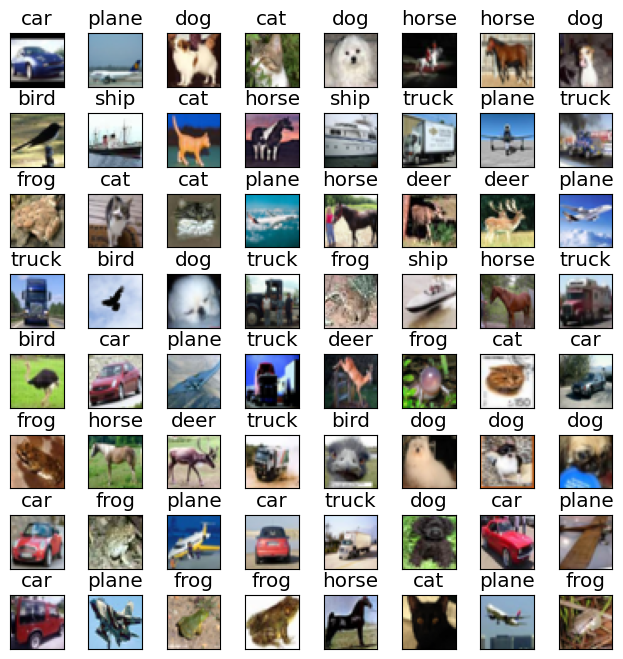

In [6]:
import os
import torchvision
import torchvision.transforms as tvtf

cfar10_labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
data_root = os.path.expanduser('~/.pytorch-datasets')

cifar10_train_ds = torchvision.datasets.CIFAR10(
    root=data_root, download=True, train=True,
    transform=tvtf.ToTensor()
)

print('Number of samples:', len(cifar10_train_ds))

# Plot them with a helper function
fig, axes = plot.dataset_first_n(cifar10_train_ds, 64,
                                 show_classes=True, class_labels=cfar10_labels,
                                 nrows=8, hspace=0.5)

Now that we've loaded the entire CIFAR-10 dataset, we would like to work with a smaller subset
from it to reduce runtime of the code in this notebook.
A simple way to achieve this with `Datasets` is to wrap a `Dataset` in another `Dataset` that does this for us. This will make it easy to use our subset with `DataLoader`s as you will see later.

**TODO** Complete the implementation of `SubsetDataset` in `hw1/datasets.py` and use the following code block to test.

In [7]:
subset_len = 5000
subset_offset = 1234
cifar10_train_subset_ds = hw1datasets.SubsetDataset(cifar10_train_ds, subset_len, subset_offset)

dataset_x, dataset_y  = cifar10_train_ds[subset_offset + 10]
subset_x, subset_y  = cifar10_train_subset_ds[10]

# Tests
test.assertEqual(len(cifar10_train_subset_ds), subset_len)
test.assertTrue(torch.all(dataset_x == subset_x))
test.assertEqual(dataset_y, subset_y)
with test.assertRaises(IndexError, msg="Out of bounds index should raise IndexError"):
    tmp = cifar10_train_subset_ds[subset_len]

Notice that when we initialized the `Dataset` instance for CIFAR-10, we provided a `transform` parameter.
This is a way to specify an arbitrary transformation that should be run on each sample prior to returning it from the dataset.

In the above, we used the `ToTensor()` transformation from `torchvision.transforms` to convert the
images from a PIL (Python Imaging Library) image object which has a shape of `32x32x3` and values in range \[0, 255\] into a pytorch `Tensor` of shape `3x32x32` and values in range \[0, 1\].

To demonstrate the use of transforms, we'll implement two custom transforms which invert the colors and flip the images around the horizontal axis.

**TODO** Complete the `InvertColors` and `FlipUpDown` classes in the `hw1/transforms.py` module.

Files already downloaded and verified


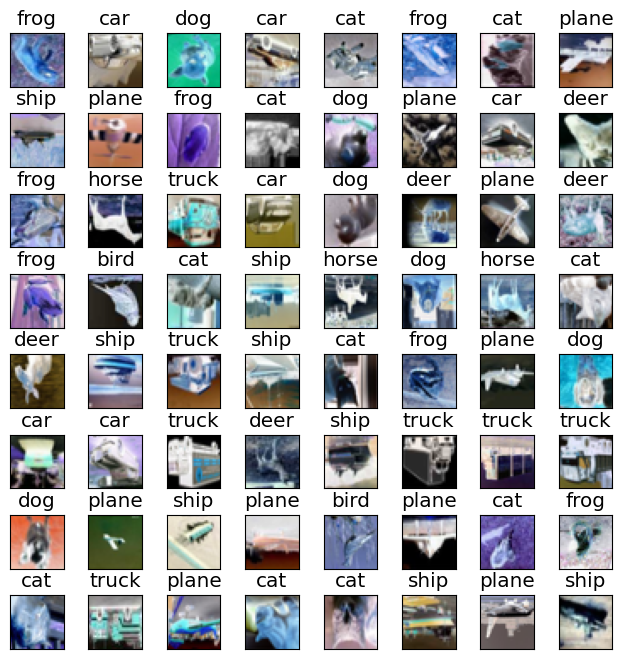

In [8]:
import hw1.transforms as hw1transforms

cifar10_inverted_ds = torchvision.datasets.CIFAR10(
    root=data_root, download=True, train=True,
    transform=tvtf.Compose([ # Compose allows us to chain multiple transforms in a sequence
        tvtf.ToTensor(), # Convert PIL image to pytorch Tensor (C,H,W) in range [0,1]
        hw1transforms.InvertColors(),
        hw1transforms.FlipUpDown(),
    ])
)

fig, axes = plot.dataset_first_n(cifar10_inverted_ds, 64,
                                 show_classes=True, class_labels=cfar10_labels,
                                 nrows=8, hspace=0.5)

test.assertTrue(torch.allclose(cifar10_train_ds[0][0], torch.flip(1.-cifar10_inverted_ds[0][0], [1])),
               "Wrong custom transform")

### `DataLoader`s and `Sampler`s
<a id=part1_3></a>

We have seen that a `Dataset` is simply an iterable allowing us to iterate over samples and posssible to also access them by index.
Simple to implement, but not very powerful.
The real benefit is when combining them with `DataLoader`.
A `DataLoader` samples a batch of samples from the dataset according to logic defined by a `Sampler` object.
The sampler decides how to partition the dataset into batches of `N` samples.
The `DataLoader` additionally handles loading samples in parallel to speed up creation of a batch.

A major motivation here is memory usage. When combining a `DataLoader` with a `Dataset` we can easily
control memory constraints by simply setting the batch size.
This is important since large datasets (e.g. ImageNet) do not fit in memory of most machines.
Since a `Dataset` can lazily load samples from disk on access,
and the `DataLoader` can sample random samples from it in parallel, we are provided with a simple
yet high-performance mechanism to iterate over random batches from our dataset without needing to
hold all of it in memory.

Let's create a basic `DataLoader` for our CIFAR-10 dataset.
Run the follwing code block multiple times and observe that different samples are shown each time in the first few batches.

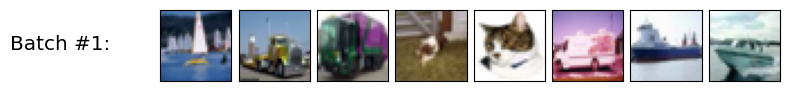

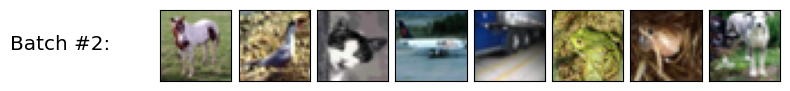

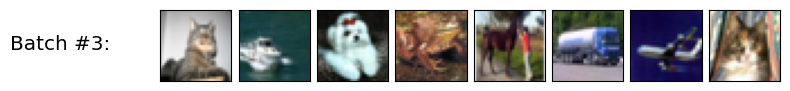

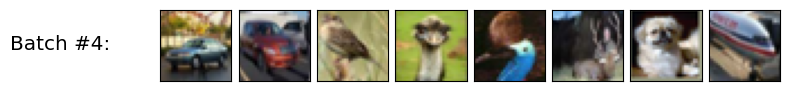

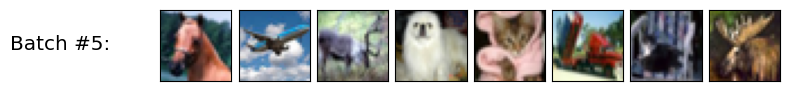

In [9]:
# Create a simple DataLoader that partitions the data into batches
# of size N=8 in random order, using two background proceses
cifar10_train_dl = torch.utils.data.DataLoader(
    cifar10_train_ds, batch_size=8, shuffle=True, num_workers=2
)

# Iterate over batches sampled with our DataLoader
num_batches_to_show = 5
for idx, (images, classes) in enumerate(cifar10_train_dl):
    # The DataLoader returns a tuple of:
    # images: Tensor of size NxCxWxH
    # classes: Tensor of size N
    fig, axes = plot.tensors_as_images(images, figsize=(8, 1))
    fig.suptitle(f'Batch #{idx+1}:', x=0, y=0.6)
    if idx >= num_batches_to_show - 1:
        break

Here, we specified `shuffle=True` to the `DataLoader`. This automatically created a `Sampler` which just returns indices from the `DataSet` in a random order.

To better control the content of the batches, we can create our own custom sampler.
Imagine we want each batch to contain one sample from the beginning of the dataset and
another from the end. If we have `N` samples, we would like to get the following sequence of indices: \[0, N-1, 1, N-2, 2, N-3, ...\] and then use a`batch_size` of 2.

**TODO** Implement the `FirstLastSampler` class in the `hw1/dataloaders.py` module.

C:\Users\AcerC\anaconda3\envs\cs236781-hw\lib\site-packages\torch\utils\data\sampler.py:65: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


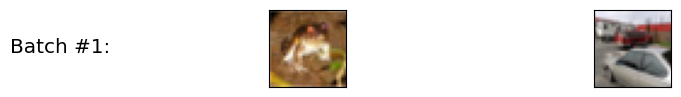

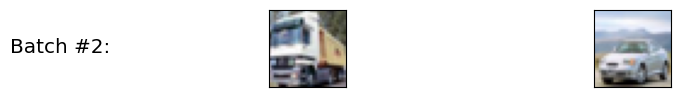

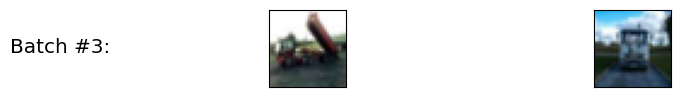

In [10]:
import hw1.dataloaders as hw1dataloaders

# Test sampler with odd number of elements
sampler = hw1dataloaders.FirstLastSampler(list(range(5)))
test.assertEqual(list(sampler), [0,4, 1,3, 2,])

# Test sampler with evennumber of elements
sampler = hw1dataloaders.FirstLastSampler(list(range(6)))
test.assertEqual(list(sampler), [0,5, 1,4, 2,3])


# Create a DataLoader that partitions the data into batches
# of size N=2 in an order determined by our custom sampler
cifar10_train_dl = torch.utils.data.DataLoader(
    cifar10_train_ds, batch_size=2, num_workers=0,
    sampler=hw1dataloaders.FirstLastSampler(cifar10_train_ds),
)

# Iterate over batches sampled with our DataLoader
num_batches_to_show = 3
for idx, (images, classes) in enumerate(cifar10_train_dl):
    fig, axes = plot.tensors_as_images(images, figsize=(8, 1))
    fig.suptitle(f'Batch #{idx+1}:', x=0, y=0.6)
    if idx >= num_batches_to_show - 1:
        break

### Training, Validation and Test Sets
<a id=part1_4></a>

Now that we know about `DataLoaders` we can use them to do something useful: split a training dataset into **Training and Validation** sets.

A common issue in machine learning models is abundance of hyperparameters that must be selected prior to training the model on data. These hyperparameters may be part of the model itself or part of the training process. 
We would like to determine which hyperparameter selection can best fit the training data, and, more importantly, can be able to generalize to unseen data.

A prevalent approach is therefore to split the training dataset into two parts:
One for actual training, i.e. tuning model parameters e.g. weights in the case of neural nets,
and another for validation, i.e. comparing one model or set of hyperparameters to another.
After the best model is selected (by seeking the minimal validation error), it can be retrained with the entire training set.

![img](https://cdn-images-1.medium.com/max/1600/1*Nv2NNALuokZEcV6hYEHdGA.png)

**TODO** Implement the function `create_train_validation_loaders` in the `hw1/dataloaders.py` module.
Use the following code block to check your implementation.

In [11]:
# Testing the train/validation split dataloaders
import hw1.dataloaders as hw1dataloaders

validation_ratio = 0.2
dl_train, dl_valid = hw1dataloaders.create_train_validation_loaders(cifar10_train_ds, validation_ratio)

train_idx = set(dl_train.sampler.indices)
valid_idx = set(dl_valid.sampler.indices)
train_size = len(train_idx)
valid_size = len(valid_idx)
print('Training set size: ', train_size)
print('Validation set size: ', valid_size)

# Tests
test.assertEqual(train_size+valid_size, len(cifar10_train_ds), "Incorrect total number of samples")
test.assertEqual(valid_size, validation_ratio * (train_size + valid_size), "Incorrect ratio")
test.assertTrue(train_idx.isdisjoint(valid_idx), "Train and validation sets are not disjoint")

Training set size:  40000
Validation set size:  10000


### Questions

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw1/answers.py`.

In [12]:
from cs236781.answers import display_answer
import hw1.answers

#### Question 1

Determine whether each of the following statements is **true or false**, and explain why in detail:

1. Any split of the data into two disjoint subsets would constitute an equally useful train-test split.
2. The test-set should be used during cross-validation.
3. After performing cross-validation, we use the validation-set performance of each fold as a proxy for the model's generalization error.
4. Injecting noise into the labels can help validate the robustness of the model.

In [13]:
display_answer(hw1.answers.part1_q1)


### **1) False**  
Splitting the data with a bad ratio may not allow for enough training examples, unbalanced distributions can harm generalization, and issues like temporal leakage (e.g., training on future data and testing on past data) can introduce overfitting. In general, we want the split to preserve the properties of the full dataset, such as distribution, noise, temporal dependencies, etc.

---

### **2) False**  
The test set should not be used during cross-validation because tuning parameters based on test performance causes overfitting to the test set. This prevents the test set from serving as an unbiased measure of true generalization.

---

### **3) True**  
Cross-validation uses validation performance on each fold as a proxy for generalization error on unseen data. The test set is then used only once at the end to obtain a final, unbiased estimate of performance on truly unseen data.

---

### **4) True**  
Injecting noise into labels helps reveal robustness because a strong model should maintain reasonable validation performance despite small amounts of corrupted data. A non-robust model will overfit the noisy labels and perform poorly on the validation set, exposing sensitivity and lack of generalization.



Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



#### Question 2

Your friend has trained a simple linear regression model, e.g. $\hat{y}=w x+b$, with some training data. He then evaluated it on a disjoint test-set and concluded that the model has over-fit the training set and therefore decided to add a regularization term $\lambda |w|$ to the loss, where $\lambda$ is a hyper parameter.
In order to select the value of $\lambda$, your friend re-trained the model on his training set with different values of $\lambda$ and then chose the value which produced the best results on the test set.

Is your friend's approach justified? Explain why or why not.

In [14]:
display_answer(hw1.answers.part1_q2)


**No. This is a terrible idea! Basically they are using the test set as a validation set - while it woud still produce
 a model that "might" generalize well, in order to actually measure generalization error,
we need to use a new separate test set. Using the test set for to pick the best parameters would lead to 
overfitting as the test-error is no longer "error on unseen data" and the test error to be unrepresentative of the generalization error.**

Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

